In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
gray_img = cv2.imread('monkey_image.png', cv2.IMREAD_GRAYSCALE)

In [3]:
gray_img

array([[160,  60,  53, ..., 124, 169, 196],
       [128, 111,  43, ..., 143, 164, 138],
       [ 84, 125,  51, ..., 110,  97,  89],
       ...,
       [155, 160, 155, ...,  90,  98,  86],
       [172, 155, 145, ...,  86,  87,  75],
       [ 11,  12,  14, ...,   6,   3,   4]], dtype=uint8)

In [5]:
pd_im=pd.DataFrame(gray_img)

In [6]:
pd_im

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,160,60,53,97,151,99,67,36,77,84,...,65,110,180,137,85,75,146,124,169,196
1,128,111,43,74,99,59,72,49,102,66,...,155,160,117,79,72,140,134,143,164,138
2,84,125,51,51,107,65,65,52,119,116,...,166,105,89,109,149,136,108,110,97,89
3,77,149,105,53,90,131,58,51,77,98,...,92,92,76,133,119,94,121,79,83,76
4,95,134,145,54,83,96,82,55,60,129,...,102,74,105,143,118,103,73,65,87,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,106,126,151,168,165,143,128,129,139,144,...,73,80,90,84,115,116,107,102,102,94
508,123,148,167,151,154,140,136,145,146,138,...,87,62,95,94,99,113,96,109,98,98
509,155,160,155,161,139,136,141,144,144,155,...,85,79,80,106,102,97,102,90,98,86
510,172,155,145,131,113,131,138,140,154,159,...,78,70,85,82,94,93,89,86,87,75


In [7]:
one_col = gray_img.reshape(1,512*512)
pd_col = pd.DataFrame(one_col)

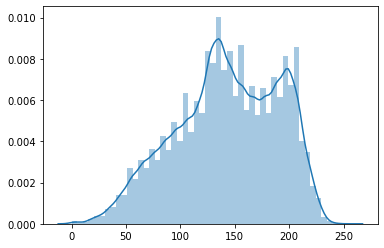

In [9]:
sns.distplot(one_col)